# Task 1  

## General instructions

First, update the following text to have a link to your Homework 3 GitHub repository:

**UPDATE THIS LINK**
https://github.com/floraham/eds-220-hwk3.git

Add comments for all your code and commit as needed. Err on the side of commenting and commiting too much for now. Points will be deducted for insufficient comments.


## About the data
In this task you will use two datsets:

**First dataset**

The first dataset contains information about [spilling incidents in the state of New York](https://data.ny.gov/Energy-Environment/Spill-Incidents/u44d-k5fk). 
The data portal has plenty of information. 
You will find extra information and metadata for this datset in the 'NYSDEC_SpillIncidents_Overview.pdf' and 'NYSDEC_SpillIncidents_DataDictionary.pdf' documents available at the portal.

You can access this datset via its URL or download it as a csv. 
If you chose to access it via URL, it will take a while to load every time you import it. 

**Second dataset**

The second dataset is a [TIGER shapefile from the United States Census Bureau](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2022.html#list-tab-790442341). 
For this task you will need to **download the 2022 counties (and equivalent) TIGER shapefile**. 
You can check the [metadata for all the TIGER shapefiles here](https://www.census.gov/programs-surveys/geography/technical-documentation/complete-technical-documentation/tiger-geo-line.html). 

## File management
Make sure all your data files are inside a directory named 'data' inside your repository's directory (working directory).

## Datasets description
Read the metadata for both datsets and write a brief description about each once. Indicate the date sources and date of access.


## NY Spills Dataset 

This dataset contains records of spills of petroleum and other hazardous materials. Under State law and regulations, spills that could pollute the lands or waters of the state must be reported by the spiller (and, in some cases, by anyone who has knowledge of the spill). Examples of what may be included in a spill record includes: Administrative information (DEC region and unique seven-digit spill number). Program facility name. Spill date/time. Location. Spill source and cause. Material(s) and material type spilled. Quantity spilled and recovered. Units measured. Surface water bodies affected. Close date (cleanup activity finished and all paperwork completed).
Date of Source: November 11, 2023
Dat of Access: November 08, 2023


## NY Counties Dataset 

The TIGER/Line Shapefiles are extracts of selected geographic and cartographic information from the
Census Bureau's Master Address File (MAF)/Topologically Integrated Geographic Encoding and
Referencing (TIGER) System (MTS). The shapefile here is of NY Counties. The TIGER/Line Shapefiles contain a standard geographic identifier (GEOID) for each entity that links to
the GEOID in the data from censuses and surveys. The TIGER/Line Shapefiles do not include
demographic data from surveys and censuses (e.g., Decennial Census, Economic Census, American
Community Survey, and the Population Estimates Program). Other, non-census, data often have this
standard geographic identifier as well. Data from many of the Census Bureau’s surveys and censuses,
including the geographic codes needed to join to the TIGER/Line Shapefiles, are available at the Census
Bureau’s public data dissemination website (https://data.census.gov/). 
Date of Source: All legal boundaries and names are as of January 1, 2022. Released September 30, 2022.
Date Accessed: Nov 8, 2022


## FINAL CODE

You will use the next cell at the end of the task. Leave it blank for now. 

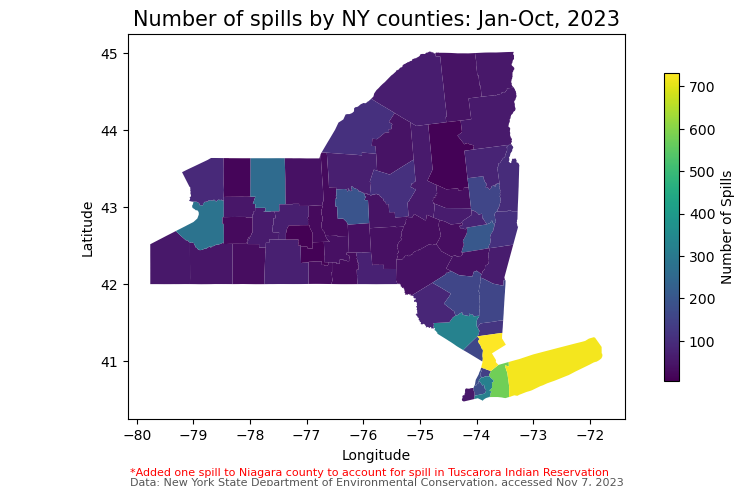

In [1]:
### ===== FINAL CODE =====

#import relevant libraries: 
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

# importing spills and counties data. 
spills = pd.read_csv('~/EDS220/eds-220-hwk3/data/Spill_Incidents_20231106.csv')
counties = gpd.read_file('~/EDS220/eds-220-hwk3/data/tl_2022_us_county2/tl_2022_us_county.shp')

# Simplifying column to lower case
spills.columns = spills.columns.str.lower()

#replacing column name spaces with "_"
spills.columns = spills.columns.str.replace(" ", "_")

#converting dates columns to datetime 
spills.spill_date = pd.to_datetime(spills.spill_date)
spills.close_date = pd.to_datetime(spills.close_date)
spills.received_date = pd.to_datetime(spills.received_date)

# select petroleum spills between 1/1/29 and 10/31/23. Storing in variable named petr_23. 
petr_23 = spills[(spills.material_family == "Petroleum") & (spills.spill_date >= "01-01-2023") & (spills.spill_date <= "10-31-2023")].copy()

# first, convert spill number to string, then group by county and count number of spills. 
petr_23.spill_number = petr_23.spill_number.astype("str")

# then resetting index
n_spills = petr_23.groupby("county").count().spill_number.reset_index()

# and convert the column name to n_spills. 
spills_per_county = n_spills.rename(columns={'spill_number':'n_spills'})

# now we work with the counties dataset. Simplifying column names. 
counties.columns = counties.columns.str.lower()

# select the NY state, which is 36 when you look up the FIPS code. 
ny_counties = counties[(counties.statefp == "36")].copy()

# Using the numpy function setdiff1d() to find the county names that are in spills_per_county, but not in ny_counties. HINT: pay attention to the example in the documentation.
np.setdiff1d(spills_per_county.county.unique(), ny_counties.name.unique()) 

# Finding the county names that are in ny_counties, but not in spills_per_county.
np.setdiff1d(ny_counties.name.unique(), spills_per_county.county.unique()) 

# Checking the number of spills in 'Tuscarora Indian Reservation'.
spills_per_county[spills_per_county.county == "Tuscarora Indian Reservation"]

# We see that St Lawrence is improperly spelled. 
# First, we need to select the first item of the index of "St Lawrence"  in that tuple using [0]
st_lawrence_index = spills_per_county[spills_per_county.county=='St Lawrence'].index[0]

# Then change "St Lawrence to St. Lawrence"
spills_per_county.at[st_lawrence_index, "county"] = "St. Lawrence"

# Now, we work with ny_counties, our other data frame. 
# rename counties columns
ny_counties.rename(columns={'name': 'county'}, inplace = True)

# Over-writing `ny_counties` as the  inner join of the `spills_per_county` and `ny_counties` dataframes.
#From our previous exploration we know that Tuscarora Indian Reservation will not be in the join. 
#Tuscarora Indian Reservation is located within Niagara county. 
ny_counties = pd.merge(spills_per_county, ny_counties, 
                     how = 'inner', 
                     on = 'county')

#Since the Tuscarora Indian Reservation does not appear in the ny_counties dataframe, 
#add one spill to Niagara county. We will add a note about this in our final map. 

niagara_index = ny_counties[ny_counties.county=='Niagara'].index[0]
ny_counties.at[niagara_index, 'n_spills'] += 1

#converting ny_counties to a geodataframe so we can plot. 
ny_counties_gpd = gpd.GeoDataFrame(ny_counties, # data
                                    geometry = 'geometry',
                                    # specify CRS
                                    crs='EPSG:4269')

# creating a chloropleth map. Adding an annotation about the spill in Niagara county. 
#setting the figure
fig, ax = plt.subplots(figsize=(10, 5))

#make sure the axis labels are on 
ax.axis('on')

#plot the data! 
ny_counties_gpd.plot(ax=ax,
                      column='n_spills',
                        legend=True,
                       legend_kwds={"shrink":.8,
                                    'label': "Number of Spills"
                                    })

# make aesthetic updates 
ax.set_title('Number of spills by NY counties: Jan-Oct, 2023',  fontsize=15)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.annotate("Data: New York State Department of Environmental Conservation, accessed Nov 7, 2023", 
            xy=(0.13, 0), # position
            xycoords='figure fraction', 
            fontsize=8, 
            color='#555555')

##annotation# 
ax.annotate("*Added one spill to Niagara county to account for spill in Tuscarora Indian Reservation", 
            xy=(0.13, 0.02 ), # position
            xycoords='figure fraction', 
            fontsize=8, 
            color='Red')

plt.show()

<!-- write your description in this markdwon cell -->

## Import libraries

In [2]:
# import libraries here
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# import numpy too
import numpy as np

## Import data 
In the next cell:

- Import the NY spills data as a variable named `spills`. 
- Import the US counties shapefile as a variable named `counties`.


<AxesSubplot:>

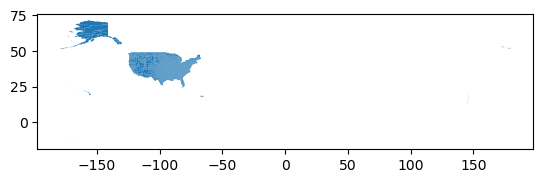

In [38]:
# import spills and counties data, and plot to check that all counties are loaded. Some of these counties didn't load the first time due to server issues. 
spills = pd.read_csv('~/EDS220/eds-220-hwk3/data/Spill_Incidents_20231106.csv')
counties = gpd.read_file('~/EDS220/eds-220-hwk3/data/tl_2022_us_county2/tl_2022_us_county.shp')

counties.plot()


## Prepare spills data

This section refers to the `spills` dataframe. 
Check the outputs carefully, they will give you context about the next exercises.

### Exploration

In the next cells:

1. Check the dataframe's head
2. Simplify column names as needed
3. Check the data types of the columns
4. Check the unique values in the `material_family` column
5. Check the unique values in the `county` column

You can add any other cells of preliminary data exploration.

In [4]:
# 1.checking spill data frame head
spills.head(5)

,Spill Number,Program Facility Name,Street 1,Street 2,Locality,County,ZIP Code,SWIS Code,DEC Region,Spill Date,Received Date,Contributing Factor,Waterbody,Source,Close Date,Material Name,Material Family,Quantity,Units,Recovered
0,107132,MH 864,RT 119/MILLWOOD RD,NaN,ELMSFORD,Westchester,NaN,6000,3,10/10/2001,10/10/2001,Unknown,NaN,Unknown,10/15/2001,unknown material,Other,10.0,Gallons,0.0
1,405586,BOWRY BAY,WATER POLL CONTROL,NaN,QUEENS,Queens,NaN,4101,2,08/21/2004,08/21/2004,Other,EAST RIVER,Unknown,09/17/2004,raw sewage,Other,0.0,Pounds,0.0
2,405586,BOWRY BAY,WATER POLL CONTROL,NaN,QUEENS,Queens,NaN,4101,2,08/21/2004,08/21/2004,Other,EAST RIVER,Unknown,09/17/2004,raw sewage,Other,0.0,NaN,0.0
3,204667,POLE 16091,GRACE AVE/BURKE AVE,NaN,BRONX,Bronx,NaN,301,2,08/02/2002,08/02/2002,Equipment Failure,NaN,Commercial/Industrial,10/28/2002,transformer oil,Petroleum,1.0,Gallons,0.0
4,210559,POLE ON,FERDALE LOMIS RD / RT 52,NaN,LIBERTY,Sullivan,NaN,5336,3,01/20/2003,01/20/2003,Traffic Accident,NaN,Commercial/Industrial,01/22/2003,transformer oil,Petroleum,6.0,Gallons,6.0


In [5]:
# 2.  Simplify column names as needed: lower case, replace space with "_", made sure all dates are converted to datetime
spills.columns = spills.columns.str.lower()
spills.columns = spills.columns.str.replace(" ", "_")
spills.spill_date = pd.to_datetime(spills.spill_date)
spills.close_date = pd.to_datetime(spills.close_date)
spills.received_date = pd.to_datetime(spills.received_date)


In [6]:
# 3. Check the data types of the columns
spills.dtypes

spill_number                      int64
program_facility_name            object
street_1                         object
street_2                         object
locality                         object
county                           object
zip_code                         object
swis_code                         int64
dec_region                        int64
spill_date               datetime64[ns]
received_date            datetime64[ns]
contributing_factor              object
waterbody                        object
source                           object
close_date               datetime64[ns]
material_name                    object
material_family                  object
quantity                        float64
units                            object
recovered                       float64
dtype: object

In [7]:
# 4. Check the unique values in the `material_family` column
spills.material_family.unique()

array(['Other', 'Petroleum', 'Hazardous Material', 'Oxygenates'],
      dtype=object)

In [8]:
# 5. Check the unique values in the `county` column
spills.county.unique()

array(['Westchester', 'Queens', 'Bronx', 'Sullivan', 'Cortland',
       'New York', 'Ulster', 'Kings', 'Orange', 'Dutchess', 'Onondaga',
       'Saratoga', 'Cayuga', 'Oswego', 'Warren', 'Niagara', 'Rockland',
       'Nassau', 'Jefferson', 'Schenectady', 'Albany', 'Monroe',
       'St Lawrence', 'Richmond', 'Clinton', 'Lewis', 'Essex', 'Chenango',
       'Erie', 'Livingston', 'Wayne', 'Suffolk', 'Orleans', 'Ontario',
       'Genesee', 'Otsego', 'Tompkins', 'Madison', 'Chemung', 'Seneca',
       'Oneida', 'Broome', 'Hamilton', 'Washington', 'Schuyler',
       'Franklin', 'Columbia', 'Fulton', 'Herkimer', 'Schoharie',
       'Rensselaer', 'Montgomery', 'Putnam', 'Delaware',
       'New Jersey - Region 2', 'Steuben', 'Tioga', 'Chautauqua',
       'Cattaraugus', 'Wyoming', 'Yates', 'Greene',
       'Pennsylvania - Region 9', 'Allegany', 'New Jersey - Region 3 (N)',
       'Cattaraugus Indian Reservation', 'New Jersey - Region 3 (T)',
       'Canada - Region 6', 'Canada - Region 9',
       '

### Data selection

1. Select data about petroleum spills that took place between January 1st 2023, and October 31st (including both dates), 2023. Store it in a variable named `petr_23`. The data selection should occur in a single line. You may add cells if you needed.

In [9]:
# select petroleum spills between 1/1/29 and 10/31/23. Store in variable named petr_23. Also check what it looks like. 
petr_23 = spills[(spills.material_family == "Petroleum") & (spills.spill_date >= "01-01-2023") & (spills.spill_date <= "10-31-2023")].copy()
petr_23.head()

,spill_number,program_facility_name,street_1,street_2,locality,county,zip_code,swis_code,dec_region,spill_date,received_date,contributing_factor,waterbody,source,close_date,material_name,material_family,quantity,units,recovered
220,2301892,*** TEST SPILL ***,*** TEST SPILL ***,NaN,*** TEST SPILL ***,Onondaga,00000,3415,7,2023-06-06,2023-06-06,Tank Test Failure,NaN,Unknown,2023-07-12,#2 fuel oil,Petroleum,0.0,Gallons,0.0
221,2301892,*** TEST SPILL ***,*** TEST SPILL ***,NaN,*** TEST SPILL ***,Onondaga,00000,3415,7,2023-06-06,2023-06-06,Tank Test Failure,NaN,Unknown,2023-07-12,"used oil (heating, on-site consumption)",Petroleum,0.0,NaN,0.0
222,2301892,*** TEST SPILL ***,*** TEST SPILL ***,NaN,*** TEST SPILL ***,Onondaga,00000,3415,7,2023-06-06,2023-06-06,Tank Test Failure,NaN,Unknown,2023-07-12,#2 fuel oil (on-site consumption),Petroleum,0.0,NaN,0.0
223,2301892,*** TEST SPILL ***,*** TEST SPILL ***,NaN,*** TEST SPILL ***,Onondaga,00000,3415,7,2023-06-06,2023-06-06,Tank Test Failure,NaN,Unknown,2023-07-12,Diesel (E-Gen),Petroleum,0.0,NaN,0.0
225,2301892,*** TEST SPILL ***,*** TEST SPILL ***,NaN,*** TEST SPILL ***,Onondaga,00000,3415,7,2023-06-06,2023-06-06,Tank Test Failure,NaN,Unknown,2023-07-12,waste oil/used oil,Petroleum,0.0,NaN,0.0


2. Verify that `petr_23` only has data for petroleum spills 

In [10]:
# checking that petr_23 only has data for petroleum spills with unique() 
petr_23.material_family.unique()

array(['Petroleum'], dtype=object)

3. Verify that `petr_23` only has data for 2023. 
HINT: if you converted the `spill_date` column to datetime, you can use `petr_23.spill_date.dt.year.unique()`

In [11]:
# verifying petr_23 only has data for 23 and select year with unique. Should only see 2023. 
petr_23.spill_date.dt.year.unique()


array([2023])

4. Verify that `petr_23` only has data from January to October. 

In [12]:
# Check months with unique. 
petr_23.spill_date.dt.month.unique()

array([ 6,  8,  9,  7,  1,  2,  3, 10,  5,  4])

### Data aggregation

Create new dataframe named `spills_per_county` with the number of petroleum spills per county from January to October 2023 (i.e. use the `petr_23` dataframe).

The resulting `spills_per_county` dataframe must be as follows:

- Index: integer numbers starting from 0
- Column one: county names, column name = `county`
- Column two: number of petroleum spills per county in 2023, column name = `n_spills`

You may add cells if you needed.

In [13]:
# first, convert spill number to string, then group by county and count number of spills. 
# then reset index and convert the column name eto n_spills. 

petr_23.spill_number = petr_23.spill_number.astype("str")

n_spills = petr_23.groupby("county").count().spill_number.reset_index()

spills_per_county = n_spills.rename(columns={'spill_number':'n_spills'})
spills_per_county


,county,n_spills
0,Albany,204
1,Allegany,30
2,Bronx,143
3,Broome,74
4,Cattaraugus,46
...,...,...
59,Washington,96
60,Wayne,38
61,Westchester,733
62,Wyoming,24


## Prepare counties data

This section refers to the `counties` geodataframe. 
Check the outputs carefully, they will give you context about the next exercises.

### Exploration

In the next cells:

1. Check the geo-dataframe's head
2. Simplify column names as needed
3. Check the data types of the columns
4. Check the geo-dataframe's CRS
5. Plot the geo-dataframe.

You can add any other cells of preliminary data exploration.

In [14]:
# checking geo-dataframe's head
counties.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477644346,10691216,+41.9158651,-096.7885168,"POLYGON ((-96.55515 41.91587, -96.55515 41.914..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680980770,61564427,+46.2946377,-123.4244583,"POLYGON ((-123.72755 46.26449, -123.72755 46.2..."
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016818946,29090018,+34.3592729,-104.3686961,"POLYGON ((-104.89337 34.08894, -104.89337 34.0..."
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,None,None,A,2169272978,22847034,+40.7835474,-096.6886584,"POLYGON ((-96.68493 40.52330, -96.69219 40.523..."
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645185,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27370 40.11840, -98.27374 40.122..."


In [15]:
# 2. simplifying column names. 
counties.columns = counties.columns.str.lower()


In [16]:
# 3. checking the column data types. 
counties.dtypes

statefp       object
countyfp      object
countyns      object
geoid         object
name          object
namelsad      object
lsad          object
classfp       object
mtfcc         object
csafp         object
cbsafp        object
metdivfp      object
funcstat      object
aland          int64
awater         int64
intptlat      object
intptlon      object
geometry    geometry
dtype: object

In [17]:
# 4.  Check the geo-dataframe's CRS
counties.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

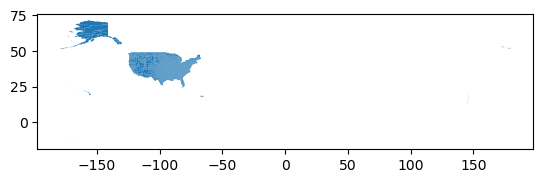

In [18]:
# 5. Plot the geo-dataframe.
counties.plot()

### Data selection

Select all the counties for the state of New York in a new variable `ny_counties` and plot them. HINT: to find which counties correspond to NY, look at the metadata.

In [19]:
# select the NY state, which is 36 when you look up the FIPS code. 
ny_counties = counties[(counties.statefp == "36")].copy()

## Merging

The goal of this section is to create a single dataframe with the number of spills per county and the corresponding geometries for each county.

### Explore data

In the next cells:

1. Print the names of counties in `ny_counties`, without repetition.
2. Print the names of counties in `spills_per_county`, without repetition. (Do you notice anything?)
3. Use the [`numpy` function `setdiff1d()`](https://numpy.org/doc/stable/reference/generated/numpy.setdiff1d.html) to find the county names that are in `spills_per_county`, but not in `ny_counties`. HINT: pay attention to the example in the documentation.
4. Find the county names that are in `ny_counties`, but not in `spills_per_county`.
5. Check the number of spills in 'Tuscarora Indian Reservation'.


In [20]:
# 1. Print the names of counties in ny_counties, without repetition.
ny_counties.name.unique()

array(['Steuben', 'Saratoga', 'Allegany', 'Oswego', 'Ulster',
       'St. Lawrence', 'Schuyler', 'Essex', 'Suffolk', 'Hamilton',
       'Dutchess', 'Otsego', 'Tompkins', 'Albany', 'Cayuga', 'Greene',
       'Herkimer', 'Warren', 'Jefferson', 'Clinton', 'Nassau', 'Madison',
       'Washington', 'Westchester', 'Lewis', 'Ontario', 'Cortland',
       'Richmond', 'Erie', 'Putnam', 'Montgomery', 'Sullivan', 'Orleans',
       'Oneida', 'Cattaraugus', 'Yates', 'Tioga', 'Monroe', 'Schoharie',
       'Broome', 'Rensselaer', 'Seneca', 'Queens', 'Genesee', 'Wayne',
       'Niagara', 'Kings', 'Chemung', 'Wyoming', 'New York', 'Columbia',
       'Chautauqua', 'Franklin', 'Onondaga', 'Chenango', 'Fulton',
       'Rockland', 'Livingston', 'Delaware', 'Orange', 'Schenectady',
       'Bronx'], dtype=object)

In [21]:
# 2. Print the names of counties in spills_per_county, without repetition. 
spills_per_county.county.unique()

#(Do you notice anything?)
#I noticed that there's quite a lot of overlap between the two dataframes, 
#but also means there are some counties that are in one and not in the other. 

array(['Albany', 'Allegany', 'Bronx', 'Broome', 'Cattaraugus', 'Cayuga',
       'Chautauqua', 'Chemung', 'Chenango', 'Clinton', 'Columbia',
       'Cortland', 'Delaware', 'Dutchess', 'Erie', 'Essex', 'Franklin',
       'Fulton', 'Genesee', 'Greene', 'Hamilton', 'Herkimer', 'Jefferson',
       'Kings', 'Lewis', 'Livingston', 'Madison', 'Monroe', 'Montgomery',
       'Nassau', 'New Jersey - Region 2', 'New York', 'Niagara', 'Oneida',
       'Onondaga', 'Ontario', 'Orange', 'Orleans', 'Oswego', 'Otsego',
       'Putnam', 'Queens', 'Rensselaer', 'Richmond', 'Rockland',
       'Saratoga', 'Schenectady', 'Schoharie', 'Schuyler', 'Seneca',
       'St Lawrence', 'Steuben', 'Suffolk', 'Sullivan', 'Tioga',
       'Tompkins', 'Tuscarora Indian Reservation', 'Ulster', 'Warren',
       'Washington', 'Wayne', 'Westchester', 'Wyoming', 'Yates'],
      dtype=object)

In [22]:
# 3. Use the numpy function setdiff1d() to find the county names that are in spills_per_county, but not in ny_counties. HINT: pay attention to the example in the documentation.

np.setdiff1d(spills_per_county.county.unique(), ny_counties.name.unique()) 


array(['New Jersey - Region 2', 'St Lawrence',
       'Tuscarora Indian Reservation'], dtype=object)

In [23]:
# 4. Find the county names that are in ny_counties, but not in spills_per_county.

np.setdiff1d(ny_counties.name.unique(), spills_per_county.county.unique()) 

array(['St. Lawrence'], dtype=object)

In [24]:
# 5. Check the number of spills in 'Tuscarora Indian Reservation'.
spills_per_county[spills_per_county.county == "Tuscarora Indian Reservation"]

,county,n_spills
56,Tuscarora Indian Reservation,1


### Data updates

In this section we will update 'St Lawrence' to 'St. Lawrence' in `spills_per_county` data frame.

In the next cells:
1. Check the row in `spills_per_county` that has 'St Lawrence'
2. Run the code and read the explanation in the comments
3. Run the code and read the explanation in the comments
4. Use the `st_lawrence_index` and `at` to update St Lawrence name in `spills_per_county` dataframe
5. Check the update was successfull

In [25]:
# 1.  
spills_per_county[spills_per_county.county == "St Lawrence"]

,county,n_spills
50,St Lawrence,65


In [26]:
# 2. we can get the index of that single row like this, to access the actual row index...
spills_per_county[spills_per_county.county=='St Lawrence'].index

Int64Index([50], dtype='int64')

In [27]:
# 3. we need to select the first item in that tuple using [0]
st_lawrence_index = spills_per_county[spills_per_county.county=='St Lawrence'].index[0]
st_lawrence_index

50

In [28]:
# 4. 
spills_per_county.at[st_lawrence_index, "county"] = "St. Lawrence"

In [29]:
spills_per_county.iloc[50]

county      St. Lawrence
n_spills              65
Name: 50, dtype: object

### Merge

In the following cells:
1. Use this cell to make any other updates needed for making an inner join of the `spills_per_county` and `ny_counties`. 
2. Over-write `ny_counties` as the  inner join of the `spills_per_county` and `ny_counties` dataframes.

From our previous exploration we know that Tuscarora Indian Reservation will not be in the join. Tuscarora Indian Reservation is located within Niagara county. 

3. Since the Tuscarora Indian Reservation does not appear in the `ny_counties` dataframe, add one spill to Niagara county. We will add a note about this in our final map. Add the cells you need to make this update **and** verify that the dataframe was updated.

In [30]:
# 1. rename counties columns
ny_counties.rename(columns={'name': 'county'}, inplace = True)

In [31]:
# 2. Over-write `ny_counties` as the  inner join of the `spills_per_county` and `ny_counties` dataframes.
#From our previous exploration we know that Tuscarora Indian Reservation will not be in the join. Tuscarora Indian Reservation is located within Niagara county. 

ny_counties = pd.merge(spills_per_county, ny_counties, 
                     how = 'inner', 
                     on = 'county')

In [32]:
# 3. Since the Tuscarora Indian Reservation does not appear in the ny_counties dataframe, 
#add one spill to Niagara county. We will add a note about this in our final map. 
ny_counties

niagara_index = ny_counties[ny_counties.county=='Niagara'].index[0]

#verify that the dataframe was updated.
ny_counties.iloc[niagara_index]

county                                                Niagara
n_spills                                                   88
statefp                                                    36
countyfp                                                  063
countyns                                             00974130
geoid                                                   36063
namelsad                                       Niagara County
lsad                                                       06
classfp                                                    H1
mtfcc                                                   G4020
csafp                                                    None
cbsafp                                                   None
metdivfp                                                 None
funcstat                                                    A
aland                                              1352887560
awater                                             1598842379
intptlat

In [33]:
# adding one spill to Niagara & verifying it was updated. 
ny_counties.at[niagara_index, 'n_spills'] += 1
ny_counties.iloc[niagara_index]

county                                                Niagara
n_spills                                                   89
statefp                                                    36
countyfp                                                  063
countyns                                             00974130
geoid                                                   36063
namelsad                                       Niagara County
lsad                                                       06
classfp                                                    H1
mtfcc                                                   G4020
csafp                                                    None
cbsafp                                                   None
metdivfp                                                 None
funcstat                                                    A
aland                                              1352887560
awater                                             1598842379
intptlat

In [34]:
# 3. Since the Tuscarora Indian Reservation does not appear in the ny_counties dataframe, 
#add one spill to Niagara county. We will add a note about this in our final map. 
#Add the cells you need to make this update and verify that the dataframe was updated.


#finding the index, updating niagara with one more spill, and checking that the difference is made.
niagara_index = ny_counties[ny_counties.county=='Niagara'].index[0]
ny_counties.at[niagara_index, 'n_spills'] += 1
ny_counties.iloc[niagara_index]


county                                                Niagara
n_spills                                                   90
statefp                                                    36
countyfp                                                  063
countyns                                             00974130
geoid                                                   36063
namelsad                                       Niagara County
lsad                                                       06
classfp                                                    H1
mtfcc                                                   G4020
csafp                                                    None
cbsafp                                                   None
metdivfp                                                 None
funcstat                                                    A
aland                                              1352887560
awater                                             1598842379
intptlat

In [37]:
#converting to geodataframe so that it can be plotted 
ny_counties_gpd = gpd.GeoDataFrame(ny_counties, # data
                                    geometry = 'geometry',
                                    # specify CRS
                                    crs='EPSG:4269')

ny_counties_gpd

,county,n_spills,statefp,countyfp,countyns,geoid,namelsad,lsad,classfp,mtfcc,csafp,cbsafp,metdivfp,funcstat,aland,awater,intptlat,intptlon,geometry
0,Albany,204,36,001,00974099,36001,Albany County,06,H1,G4020,None,None,None,A,1354273421,26971925,+42.5882401,-073.9740095,"POLYGON ((-73.96379 42.44162, -73.96666 42.441..."
1,Allegany,30,36,003,00974100,36003,Allegany County,06,H1,G4020,None,None,None,A,2666225086,12989848,+42.2478532,-078.0261531,"POLYGON ((-78.04342 42.51846, -78.04326 42.518..."
2,Bronx,143,36,005,00974101,36005,Bronx County,06,H6,G4020,None,None,None,C,109235674,39353304,+40.8487111,-073.8529390,"POLYGON ((-73.93381 40.88221, -73.93365 40.882..."
3,Broome,74,36,007,00974102,36007,Broome County,06,H1,G4020,None,None,None,A,1827626589,25078245,+42.1619773,-075.8302833,"POLYGON ((-75.74223 41.99805, -75.75080 41.997..."
4,Cattaraugus,46,36,009,00974103,36009,Cattaraugus County,06,H1,G4020,None,None,None,A,3388125876,36783591,+42.2390986,-078.6623320,"POLYGON ((-78.69725 41.99867, -78.69881 41.998..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,Washington,96,36,115,00974155,36115,Washington County,06,H1,G4020,None,None,None,A,2152773115,38123568,+43.3123766,-073.4394282,"POLYGON ((-73.26504 43.10615, -73.26504 43.106..."
58,Wayne,38,36,117,00974156,36117,Wayne County,06,H1,G4020,None,None,None,A,1563913376,2018184723,+43.2181139,-077.0494024,"POLYGON ((-76.70573 43.13143, -76.70561 43.129..."
59,Westchester,733,36,119,00974157,36119,Westchester County,06,H1,G4020,None,None,None,A,1115811940,179391718,+41.1526862,-073.7457526,"POLYGON ((-73.65762 40.98550, -73.65739 40.985..."
60,Wyoming,24,36,121,00974158,36121,Wyoming County,06,H1,G4020,None,None,None,A,1535219438,9158067,+42.7013627,-078.2285667,"POLYGON ((-77.95538 42.71371, -77.95537 42.713..."


## Map
Create a choropleth map of the number of petroleum spills per county in the state of New York in 2023. 
Your map should have (at least) the following updates:
- a legend indicating the number of spills
- an updated color map
- a title 
- no axis
- an annotation with the data source (New York State Department of Environmental Conservation), date of access HINT: check the graph we did for power plants, 
- an annotation indicating one spill occurred in Tuscarora Indian Reservation within Niagara county

Tuscarora Indian Reservation in Niagara county

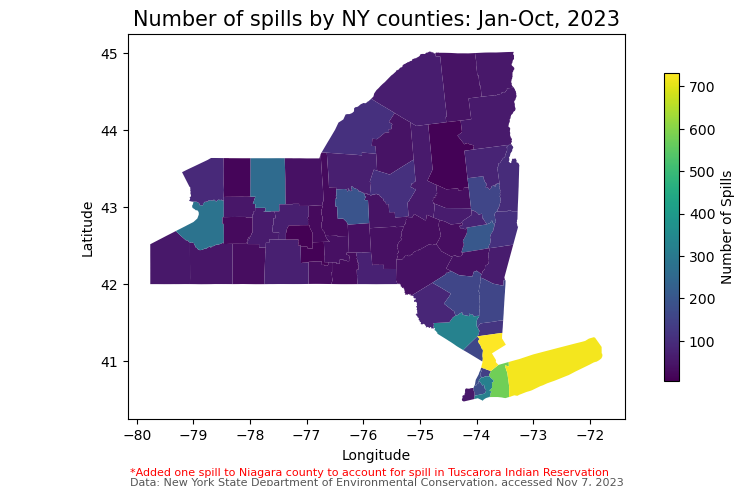

In [36]:
# creating a chloropleth map. Adding an annotation about the spill in Niagara county. 

fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('on')

ny_counties_gpd.plot(ax=ax,
                      column='n_spills',
                        legend=True,
                       legend_kwds={"shrink":.8,
                                    'label': "Number of Spills"
                                    })

ax.set_title('Number of spills by NY counties: Jan-Oct, 2023',  fontsize=15)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.annotate("Data: New York State Department of Environmental Conservation, accessed Nov 7, 2023", 
            xy=(0.13, 0), # position
            xycoords='figure fraction', 
            fontsize=8, 
            color='#555555')


##annotation# 
ax.annotate("*Added one spill to Niagara county to account for spill in Tuscarora Indian Reservation", 
            xy=(0.13, 0.02 ), # position
            xycoords='figure fraction', 
            fontsize=8, 
            color='Red')

plt.show()



## Final code

Collect all the relevant code into the first blank cell of the notebook titled "FINAL CODE". This single cell will have the end-to-end workflow: from importing libraries and loading the data, to producing the graph. The *only* ouput of this cell should be the graph you produced in the previous exercise. For each line, add a single comment explaining what the code does.